In [1]:
import numpy as np
import typing as tp
import matplotlib.pyplot as plt

In [2]:
from BaselineSolver import BaselineSolver
from IterativeSolver import IterativeSolver
from utils import run_tests, read_tests_simplex_in_ball, run_random_test

In [3]:
def get_baseline_test_results(dimension: int, number_tests: int, lowest_grid_density: float=100, highest_grid_density: float=10000,
                             silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        time, t_error = run_random_test(BaselineSolver, dimension, 
                                        {'grid_density': np.exp(np.random.uniform(np.log(lowest_grid_density), np.log(highest_grid_density)))}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [12]:
def get_iterative_test_results(dimension: int, number_tests: int, lowest_initial_grid_density: float=10, highest_initial_grid_density: float=100,
                              silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        initial_grid_density = np.exp(np.random.uniform(np.log(lowest_initial_grid_density), np.log(highest_initial_grid_density)))
        time, t_error = run_random_test(IterativeSolver, dimension, 
                                        {'initial_grid_density': initial_grid_density}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [13]:
def plot_test_results(times: np.ndarray, t_errors: np.ndarray, title: str, fit=True) -> None:
    t_errors_without_zeros = np.copy(t_errors)
    t_errors_without_zeros[t_errors_without_zeros == 0.] = 1e-16
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    plt.xlabel('time, s')
    plt.ylabel('t_error')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.scatter(times, t_errors_without_zeros)
    if fit:
        a, b = np.polyfit(np.log(times), np.log(t_errors_without_zeros), 1)
        plt.plot(times, np.exp(a * np.log(times) + b), 'r', label=f't_error ~ 1 / time^{-a:.2f}')
        plt.legend()
    plt.title(title)
    plt.savefig(f'figures/{title.replace(" ", "_").replace(",", "")}')

nce near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
17 /   2.194e-07 /    3.55e-06 (  perturbed bounds)
17 /   2.194e-07 /    3.55e-06 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
1534 /   5.859e-06 /    0.004324 (  perturbed bounds)
1534 /   5.859e-06 /    0.004324 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
837 /    3.19e-06 /   0.0008576 (  perturbed bounds)
829 /   3.015e-06 /   0.0008026 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
17 /   2.194e-07 /    3.55e-06 (  perturbed bounds)
17 /   2.194e-07 /    3.55e-06 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
1789 /   7.545e-06 /    0.005526 ( 

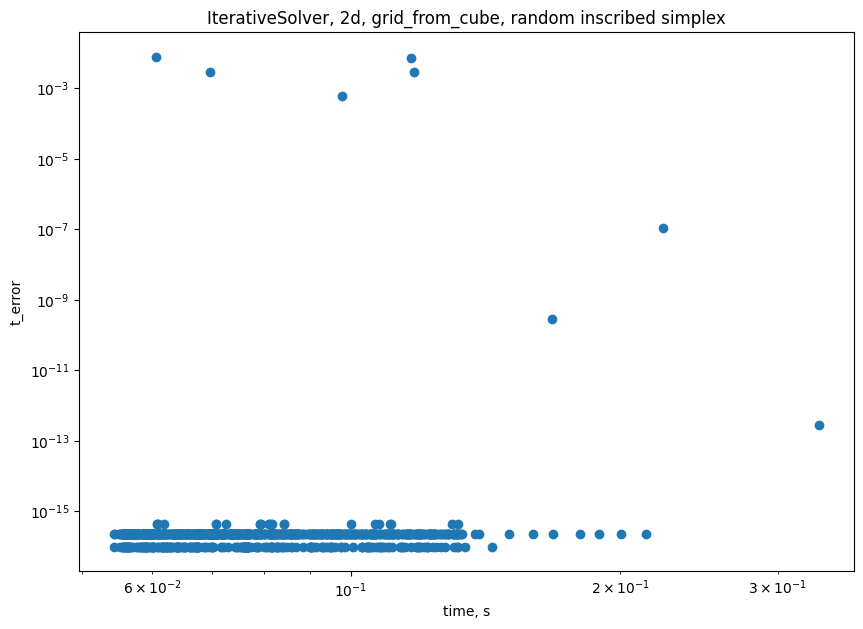

In [14]:
times_iterative_2d, errors_iterative_2d = get_iterative_test_results(2, 1000, silent=True)
plot_test_results(times_iterative_2d, errors_iterative_2d, 'IterativeSolver, 2d, grid_from_cube, random inscribed simplex', fit=False)

costs
num / max / sum primal infeasiblitiles
406 /   1.511e-06 /   0.0003322 (  perturbed bounds)
406 /   1.511e-06 /   0.0003322 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
4092 /   5.775e-05 /       0.118 (  perturbed bounds)
4092 /   5.775e-05 /       0.118 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
250 /   2.296e-05 /    0.001109 (  perturbed bounds)
250 /   2.296e-05 /    0.001109 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
888 /   3.022e-07 /   0.0001689 (  perturbed bounds)
888 /   3.022e-07 /   0.0001689 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
987 /   6.192e-06 /    0.001945 (  perturbed bounds)
987 /   6.192e-06 / 

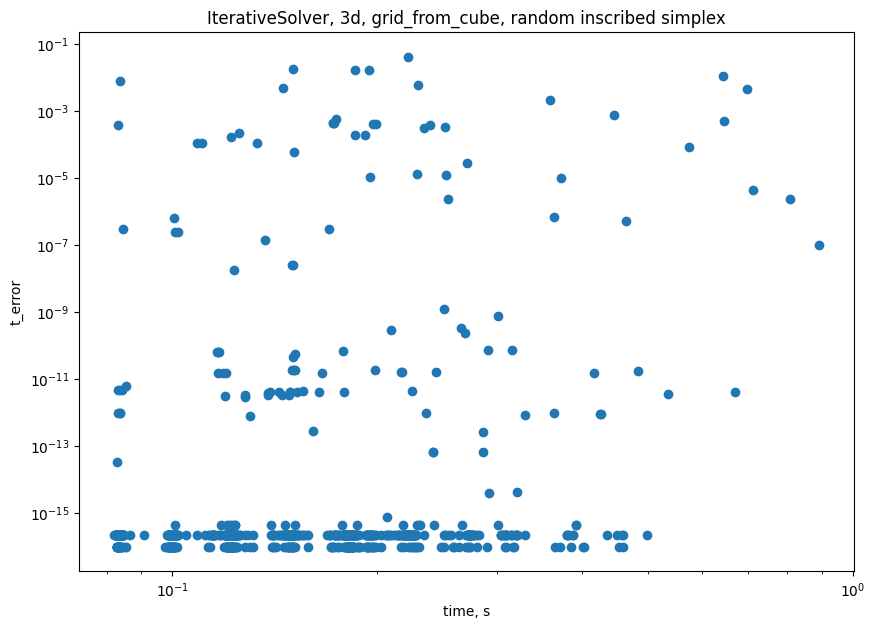

In [15]:
times_iterative_3d, errors_iterative_3d = get_iterative_test_results(3, 1000, silent=True)
plot_test_results(times_iterative_3d, errors_iterative_3d, 'IterativeSolver, 3d, grid_from_cube, random inscribed simplex', fit=False)

nds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
1712 /   5.584e-06 /     0.00284 (  perturbed bounds)
1712 /   5.584e-06 /     0.00284 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
237 /   3.967e-07 /   4.889e-05 (  perturbed bounds)
237 /   3.967e-07 /   4.889e-05 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
385 /   5.779e-06 /   0.0007607 (  perturbed bounds)
385 /   5.779e-06 /   0.0007607 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
1066 /   5.738e-06 /    0.002158 (  perturbed bounds)
1066 /   5.738e-06 /    0.002158 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitil

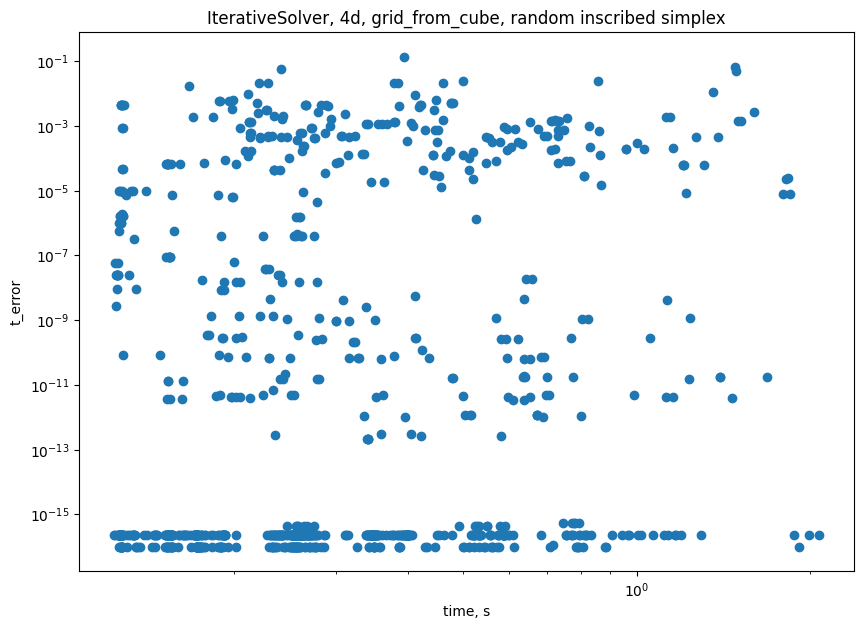

In [16]:
times_iterative_4d, errors_iterative_4d = get_iterative_test_results(4, 1000, silent=True)
plot_test_results(times_iterative_4d, errors_iterative_4d, 'IterativeSolver, 4d, grid_from_cube, random inscribed simplex', fit=False)

ax / sum primal infeasiblitiles
884 /   7.185e-07 /   0.0002307 (  perturbed bounds)
884 /   7.185e-07 /   0.0002307 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
884 /   7.185e-07 /   0.0002307 (  perturbed bounds)
884 /   7.185e-07 /   0.0002307 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
314 /   6.385e-06 /   0.0006209 (  perturbed bounds)
314 /   6.385e-06 /   0.0006209 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
264 /   1.218e-06 /   8.478e-05 (  perturbed bounds)
264 /   1.218e-06 /   8.478e-05 (unperturbed bounds)
Solve 1: Forcing phase 2 since near primal feasible with unperturbed costs
num / max / sum primal infeasiblitiles
176 /    7.59e-07 /     5.8e-05 (  perturbed bounds)
142 /   6.119e-07 /   3.674e-05 (un

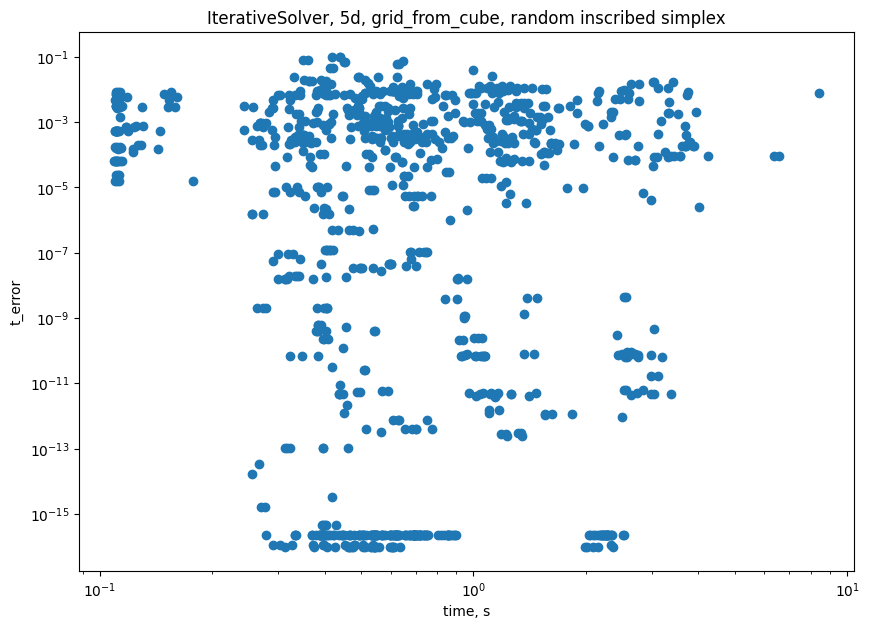

In [17]:
times_iterative_5d, errors_iterative_5d = get_iterative_test_results(5, 1000, silent=True)
plot_test_results(times_iterative_5d, errors_iterative_5d, 'IterativeSolver, 5d, grid_from_cube, random inscribed simplex', fit=False)

times_baseline_2d, errors_baseline_2d = get_baseline_test_results(2, 1000)

plot_test_results(times_baseline_2d, errors_baseline_2d, 'BaselineSolver, 2d, grid_from_cube, random inscribed simplex')

times_baseline_3d, errors_baseline_3d = get_baseline_test_results(3, 1000)

plot_test_results(times_baseline_3d, errors_baseline_3d, 'BaselineSolver, 3d, grid_from_cube, random inscribed simplex')

times_baseline_4d, errors_baseline_4d = get_baseline_test_results(4, 1000)

plot_test_results(times_baseline_4d, errors_baseline_4d, 'BaselineSolver, 4d, grid_from_cube, random inscribed simplex')

times_baseline_5d, errors_baseline_5d = get_baseline_test_results(5, 1000)

plot_test_results(times_baseline_5d, errors_baseline_5d, 'BaselineSolver, 5d, grid_from_cube, random inscribed simplex')

In [10]:
np.vstack((np.array([[1,1],[2,2],[3,3]]), np.array([4,4])))

array([[1, 1],
       [2, 2],
       [3, 3],
       [4, 4]])

In [11]:
np.zeros((1,3)), np.array([[4,4]])

(array([[0., 0., 0.]]), array([[4, 4]]))

run_tests(IterativeSolver, 5, {'initial_grid_density': 1000, 'initial_cap_radius': 0.01, 'density_of_gridpoints_in_unit_cap': 10}, 
          read_tests_simplex_in_ball, f'./tests/5d/simplex-in-ball/')